In [149]:
import matplotlib.pyplot as plt
import pandas as pd

### With 100 points, three cases:

1. Ideal
2. Gaussian noise
3. Uniform noise

we have created a dataset with 100 points. The relation we want to investigate is

$$
2.5382 cos(x)+x^2-0.5
$$

In [150]:
import numpy as np

X = 5 * np.random.randn(100,1)
a = 2 #weight for noise
y = 2.5382 * np.cos(X) + X ** 2 - 0.5 
n = y + a*np.random.randn(100,1)
u = y + a*np.random.rand(100,1)

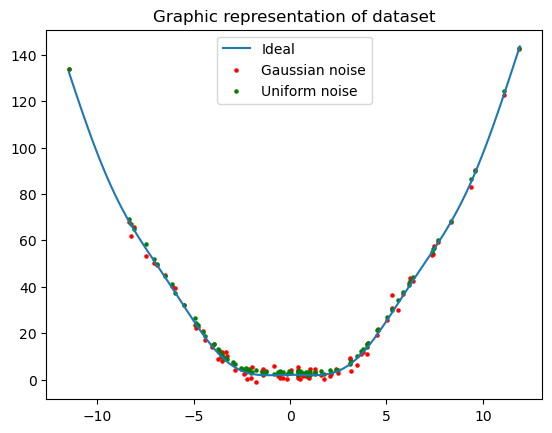

In [151]:
x = np.arange(np.min(X),np.max(X)+0.2, 0.2)
g = 2.5382 * np.cos(x) + x ** 2 - 0.5 
plt.plot(x,g, label='Ideal')
plt.scatter(X,n, label='Gaussian noise', s=5, color='r')
plt.scatter(X,u, label='Uniform noise', s=5, color='green')
plt.title('Graphic representation of dataset')
plt.legend()

from pysr import PySRRegressor

model = PySRRegressor(
    niterations=40,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)    
    procs=8,
)

In [152]:
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=40,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "sin",
        "exp",
        "log",
    ],
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)    
    warm_start=True,
    turbo=True,
    #batching=True, not so useful for this example
)

## 1. Ideal


In [153]:
model.fit(X, y)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick      score                                           equation  \
	0         0.000000                                          21.277924   
	1         2.762516                                          (x0 * x0)   
	2         0.022056                          ((x0 * x0) + -0.37965837)   
	3         0.857237                              ((x0 * x0) + cos(x0))   
	4         0.847640                ((x0 * x0) + (cos(x0) * 2.4906301))   
	5  >>>>  12.084858  (((x0 * x0) + (cos(x0) * 2.5381997)) + -0.5000...   
	6         0.000287  (((x0 * x0) + (cos(x0) * 2.5381997)) + (cos(-0...   
	
	           loss  complexity  
	0  8.378513e+02           1  
	1  3.339456e+00           3  
	2  3.195346e+00           5  
	3  1.355891e+00           6  
	4  2.488710e-01           8  
	5  7.928662e-12          10  
	6  7.921841e-12          13  
]

In [154]:
p_1 = model.predict(X)
l_1 = model.latex()
p=[]
l=[]
p.append(p_1), l.append(l_1)

(None, None)

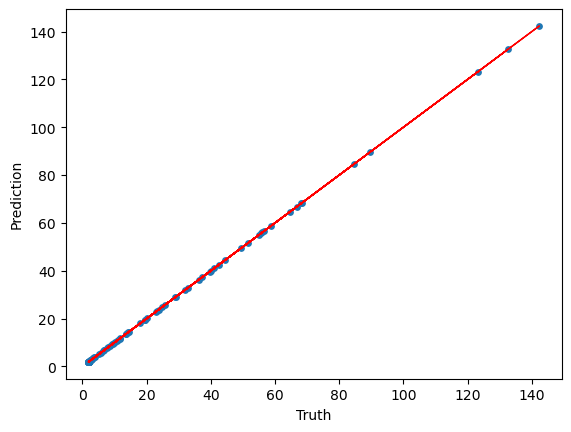

In [155]:
plt.scatter(y, p_1,s=15)
plt.plot(y,y, color='r', lw=1)
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()

In [156]:
from IPython.display import Markdown as md
md(f"The model has this equation as output: ${l[0]}$")

The model has this equation as output: $x_{0}^{2} + 2.54 \cos{\left(x_{0} \right)} - 0.500$

## 2. Gaussian noise


In [157]:
model.fit(X,n)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          21.498632   
	1         2.363452                                          (x0 * x0)   
	2         0.004460                          (x0 * (x0 + 0.054990213))   
	3         0.358947                              ((x0 * x0) + cos(x0))   
	4   >>>>  0.184457                ((x0 * x0) + (cos(x0) * 2.7779152))   
	5         0.011952  (((x0 * x0) + (cos(x0) * 2.8203332)) + -0.3344...   
	6         0.004033  ((x0 * ((x0 * 0.99452186) + 0.044046365)) + (c...   
	7         0.000001  ((x0 * ((x0 * 0.99452186) + sin(0.044046365)))...   
	8         0.002284  ((x0 * (((x0 * 0.99452186) * 0.99452186) + 0.0...   
	9         0.003799  (((x0 * ((x0 * 0.99452186) + 0.062313344)) + (...   
	10        0.006234  (((x0 * (x0 * 0.99452186)) + (cos(x0) * 2.8203...   
	11        0.064411  (((x0 * (x0 * 0.99452186)) + (cos(x0) * 2.8203...   
	
	          loss  complexity  
	0   832.944500           1  
	1     7.374752           3  
	2     7.309266           5  
	3     5.104874           6  
	4     3.529941           8  
	5     3.446562          10  
	6     3.418872          12  
	7     3.418868          13  
	8     3.411066          14  
	9     3.398132          15  
	10    3.377014          16  
	11    3.166354          17  
]

In [158]:
p_2 = model.predict(X)
l_2 = model.latex()
p.append(p_2), l.append(l_2)

(None, None)

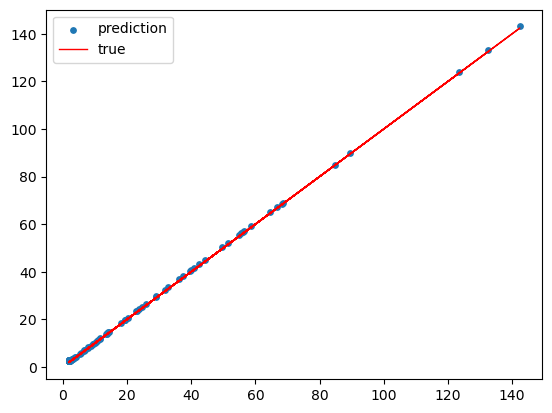

In [159]:
plt.scatter(y, p_2,s=15, label='prediction')
plt.plot(y,y, color='r', lw=1, label='true')
plt.legend()
plt.show()

In [160]:
md(f"The model has this equation as output: ${l[1]}$")

The model has this equation as output: $x_{0}^{2} + 2.78 \cos{\left(x_{0} \right)}$

## 3. Uniform noise

In [161]:
model.fit(X,u)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          22.257246   
	1        2.694054                                          (x0 * x0)   
	2        0.049607                           ((x0 * x0) + 0.60001594)   
	3        0.672199                              ((x0 * x0) + cos(x0))   
	4        0.578497                 ((x0 * x0) + (cos(x0) * 2.557661))   
	5  >>>>  0.252241  (((x0 * x0) + 0.57710063) + (cos(x0) * 2.557661))   
	6        0.031760  (((x0 * x0) + (cos(x0) * 2.5086906)) + exp(-0....   
	7        0.000599  (((x0 * x0) + (cos(x0) * 2.5086906)) + sin(exp...   
	8        0.000041  (((x0 * x0) + (cos(x0) * 2.5086906)) + (sin(si...   
	
	         loss  complexity  
	0  834.388500           1  
	1    3.813663           3  
	2    3.453461           5  
	3    1.763284           6  
	4    0.554430           8  
	5    0.334775          10  
	6    0.324310          11  
	7    0.324116          12  
	8    0.324089          14  
]

In [162]:
p_3 = model.predict(X)
l_3 = model.latex()
p.append(p_3), l.append(l_3)

(None, None)

In [163]:
md(f"The model has this equation as output: ${l[2]}$")

The model has this equation as output: $x_{0}^{2} + 2.56 \cos{\left(x_{0} \right)} + 0.577$

## Comparison beetween ideal and noised

Gaussian

I compute the diferences between ideal and noised data, and later I used the discovered formulas to do the same:

In [164]:
d_1 = y-n 
d_2 = p_1-p_2

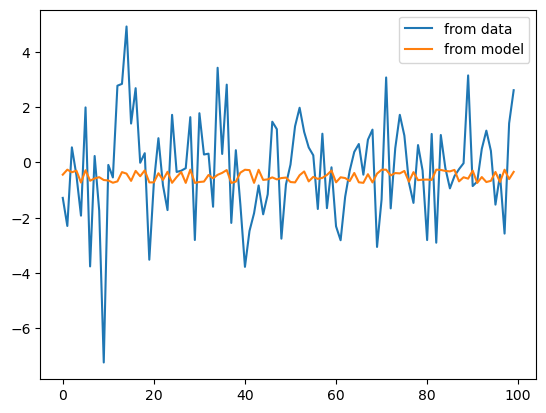

In [165]:
plt.plot(d_1, label='from data')
plt.plot(d_2, label='from model')
plt.legend()

seems that the model reduces the discrepances between ideal data and gaussian-noised data: I think that's fine because we find in both cases two formulas very similar. ($ x^2+a\cdot cos(x)+ b$, where  $a, b \in \mathbb{R}$)


Uniform

In [166]:
r_1 = y-u
r_2 = p_1-p_3

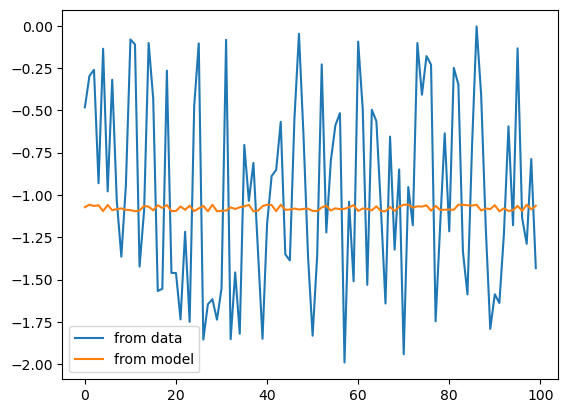

In [167]:
plt.plot(r_1, label='from data')
plt.plot(r_2, label='from model')
plt.legend()

## Tryhard #1: using only 50 points

In [168]:
X = 5 * np.random.randn(50,1)
y = 2.5382 * np.cos(X) + X ** 2 - 0.5 
n = y + a*np.random.randn(50,1)
u = y + a*np.random.rand(50,1)

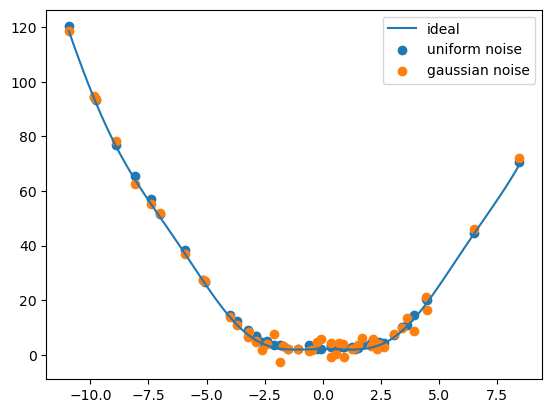

In [169]:
x = np.arange(np.min(X),np.max(X)+0.2, 0.2)
g = 2.5382 * np.cos(x) + x ** 2 - 0.5 
plt.plot(x,g, label='ideal')
plt.scatter(X,u, label='uniform noise')
plt.scatter(X,n, label='gaussian noise')
plt.legend()

Ideal

In [170]:
model.fit(X, y)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          18.840437   
	1        2.673899                                          (x0 * x0)   
	2        0.087857                            ((x0 * x0) + -0.787854)   
	3        0.677218                              ((x0 * x0) + cos(x0))   
	4        0.953703                ((x0 * x0) + (cos(x0) * 2.6484377))   
	5        2.567513  (((x0 * x0) + (cos(x0) * 2.557661)) + -0.46250...   
	6        1.315100  (((x0 * x0) + sin(-0.5372378)) + (cos(x0) * 2....   
	7        0.411682  (((x0 * x0) + sin(sin(-0.5372378))) + (cos(x0)...   
	8        0.143476  (((x0 * x0) + (sin(-0.5372378) + 0.008395257))...   
	9  >>>>  8.780354  (((2.5382 * (log(cos(log(0.94984984))) + cos(x...   
	
	           loss  complexity  
	0  8.095801e+02           1  
	1  3.852484e+00           3  
	2  3.231686e+00           5  
	3  1.641789e+00           6  
	4  2.437480e-01           8  
	5  1.434921e-03          10  
	6  3.852009e-04          11  
	7  2.552091e-04          12  
	8  2.210982e-04          13  
	9  5.224763e-12          15  
]

In [171]:
l_4 = model.latex()
p_4 = model.predict(X)
p.append(p_4), l.append(l_4)

(None, None)

In [172]:
md(f"The model has this equation as output: ${l[3]}$")

The model has this equation as output: $x_{0}^{2} + 2.54 \cos{\left(x_{0} \right)} - 0.500$

Gaussian

In [173]:
model.fit(X, n)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                          19.309147   
	1         3.649694e-08                                     exp(2.9604802)   
	2         4.646370e+00                                          (x0 * x0)   
	3         7.157635e-03                            (x0 * (x0 * 0.9903668))   
	4         3.273600e-01                              ((x0 * x0) + cos(x0))   
	5   >>>>  1.581334e-01                ((x0 * x0) + (cos(x0) * 2.7187006))   
	6         1.400137e-05  ((x0 * x0) + (-0.010829247 + (cos(x0) * 2.7163...   
	7         3.572269e-03  ((x0 * (x0 + sin(-6.2557087))) + (cos(x0) * 2....   
	8         2.537701e-02  ((x0 * x0) + (cos(x0 + -0.13527192) * exp(cos(...   
	9         2.834268e-03  ((x0 * x0) + (cos(x0 + -0.13527192) * exp(cos(...   
	10        3.480413e-03  ((x0 * x0) + (cos(x0) * exp(cos(sin(x0 * exp(s...   
	11        3.802727e-02  (((x0 * x0) + (cos(x0) + cos(x0))) + cos(x0 + ...   
	12        1.590365e-02  (((x0 * x0) + (cos(x0 + -0.49450374) + cos(x0)...   
	
	          loss  complexity  
	0   821.986630           1  
	1   821.986600           2  
	2     7.888094           3  
	3     7.775979           5  
	4     5.605113           6  
	5     4.085371           8  
	6     4.085257          10  
	7     4.070689          11  
	8     3.968687          12  
	9     3.946254          14  
	10    3.918880          16  
	11    3.772654          17  
	12    3.654544          19  
]

In [174]:
l_4 = model.latex()
p_4 = model.predict(X)
p.append(p_4), l.append(l_4)

(None, None)

In [175]:
md(f"The model has this equation as output: ${l[4]}$")

The model has this equation as output: $x_{0}^{2} + 2.72 \cos{\left(x_{0} \right)}$

uniform

In [176]:
model.fit(X, u)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          19.839111   
	1        2.763481                                          (x0 * x0)   
	2        0.006976                           ((x0 * x0) + 0.21159561)   
	3        0.819941                              ((x0 * x0) + cos(x0))   
	4        0.454664                ((x0 * x0) + (cos(x0) * 2.2764401))   
	5  >>>>  0.246083  (((x0 * x0) + (cos(x0) * 2.2764401)) + 0.43878...   
	6        0.001214  ((((x0 * x0) + 0.22922277) + (cos(x0) * 2.2764...   
	7        0.000152  ((((x0 * x0) + 0.22922277) + (cos(x0) * 2.2764...   
	8        0.004523  ((x0 * x0) + log(exp(cos(x0) + (cos(x0) + sin(...   
	9        0.016878  ((x0 * x0) + log(exp(cos(x0) + (cos(x0) + sin(...   
	
	         loss  complexity  
	0  812.351900           1  
	1    3.231582           3  
	2    3.186806           5  
	3    1.403652           6  
	4    0.565383           8  
	5    0.345620          10  
	6    0.344781          12  
	7    0.344729          13  
	8    0.337020          18  
	9    0.331379          19  
]

In [177]:
l_4 = model.latex()
p_4 = model.predict(X)
p.append(p_4), l.append(l_4)
md(f"The model has this equation as output: ${l[5]}$")

The model has this equation as output: $x_{0}^{2} + 2.28 \cos{\left(x_{0} \right)} + 0.439$

It seems that the gaussian noise has a greater disturbance on the data, in fact the expression that I found is slightly different from the ideal one. The model suffers a bit with gaussian noise, while the model is reliable with the uniform noise

## Tryhard: 5(or 2) variables



In [178]:
X = 5 * np.random.randn(100, 2)
a = 2 #weight for noise
y = 2.5382 * np.cos(X[:,1]) + X[:,0] ** 2 - 0.5
n = y + a*np.random.randn(100)
u = y + a*np.random.rand(100)

we have created a dataset with 100 points with 2 features each. The relation we want to investigate is

$$
2.5382 cos(x_1)+x_0^2-0.5
$$

## 1. Ideal

In [179]:
model.fit(X,y)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                           25.90146   
	1        2.972311                                          (x0 * x0)   
	2        0.030128                          ((x0 * x0) + -0.45113564)   
	3        0.832909                              ((x0 * x0) + cos(x1))   
	4        0.870510                ((x0 * x0) + (2.5192912 * cos(x1)))   
	5  >>>>  2.619368  (((x0 * x0) + (2.5192912 * cos(x1))) + -0.4658...   
	
	          loss  complexity  
	0  1328.468900           1  
	1     3.480448           3  
	2     3.276921           5  
	3     1.424749           6  
	4     0.249818           8  
	5     0.001326          10  
]

In [180]:
l_5 = model.latex()
p_5 = model.predict(X)
p.append(p_5), l.append(l_5)
md(f"The model has this equation as output: ${l[6]}$")

The model has this equation as output: $x_{0}^{2} + 2.52 \cos{\left(x_{1} \right)} - 0.466$

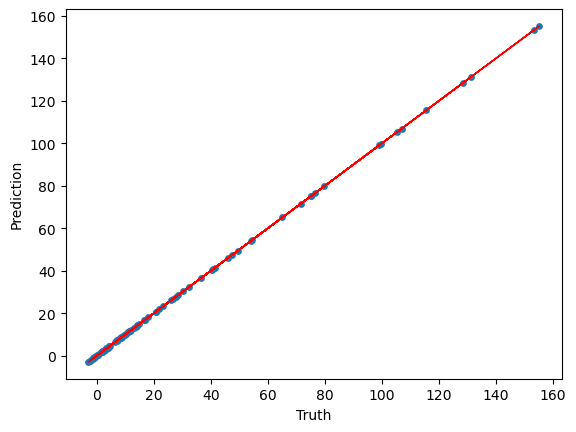

In [181]:
plt.scatter(y, p[6],s=15)
plt.plot(y,y, color='r', lw=1)
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()

## 2. Gaussian

In [182]:
model.fit(X,n)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          26.058561   
	1        2.489817                                          (x0 * x0)   
	2        0.004673                          ((x0 * x0) + -0.29352665)   
	3  >>>>  0.306534                              ((x0 * x0) + cos(x1))   
	4        0.171678                 ((x0 * x0) + (cos(x1) * 2.938925))   
	5        0.013039  (((x0 * x0) + -0.3506811) + (cos(x1) * 2.97721...   
	6        0.002044  ((((x0 * x0) + sin((x1 * x1) * -0.12234084)) +...   
	7        0.003500  ((((x0 * x0) + sin((x1 * x1) * -0.12234084)) +...   
	8        0.000025  (((((x0 * x0) + sin((x1 * x1) * -0.12234084)) ...   
	
	          loss  complexity  
	0  1346.473900           1  
	1     9.259130           3  
	2     9.172990           5  
	3     6.751263           6  
	4     4.789244           8  
	5     4.665968          10  
	6     4.609106          16  
	7     4.576959          18  
	8     4.576727          20  
]

In [183]:
l_5 = model.latex()
p_5 = model.predict(X)
p.append(p_5), l.append(l_5)
md(f"The model has this equation as output: ${l[7]}$")

The model has this equation as output: $x_{0}^{2} + \cos{\left(x_{1} \right)}$

## 3. Uniform

In [184]:
model.fit(X,u)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          26.844831   
	1        2.959589                                          (x0 * x0)   
	2        0.035115                           ((x0 * x0) + 0.49179488)   
	3        0.728990                              ((x0 * x0) + cos(x1))   
	4        0.519599                ((x0 * x0) + (cos(x1) * 2.3154364))   
	5  >>>>  0.134329   ((x0 * x0) + ((cos(x1) * 2.041628) + 0.4647595))   
	6        0.124490  ((x0 * x0) + ((sin(cos(x1)) * 2.938925) + 0.37...   
	7        0.027149  ((x0 * x0) + ((sin(sin(cos(x1))) * 2.938925) +...   
	8        0.001752  ((x0 * x0) + ((sin(cos(x1)) * (2.938925 + -0.2...   
	9        0.003936  ((x0 * x0) + ((cos(x1) * (2.938925 + (0.586561...   
	
	          loss  complexity  
	0  1331.408900           1  
	1     3.578038           3  
	2     3.335375           5  
	3     1.608972           6  
	4     0.569155           8  
	5     0.435064          10  
	6     0.384139          11  
	7     0.373850          12  
	8     0.372543          14  
	9     0.369621          16  
]

In [185]:
l_5 = model.latex()
p_5 = model.predict(X)
p.append(p_5), l.append(l_5)
md(f"The model has this equation as output: ${l[8]}$")

The model has this equation as output: $x_{0}^{2} + 2.04 \cos{\left(x_{1} \right)} + 0.465$

## 5 (3 fake) variables

In [186]:
X = 5 * np.random.randn(100, 5)
a = 2 #weight for noise
y = 2.5382 * np.cos(X[:,3]) + X[:,0] ** 2 - 0.5
n = y + a*np.random.randn(100)
u = y + a*np.random.rand(100)

we have created a dataset with 100 points with 5 features each. The relation we want to investigate is

$$
2.5382 cos(x_3)+x_0^2-0.5
$$

### Ideal

In [187]:
model.fit(X,y)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                          20.135994   
	1         5.523110e-08                                     exp(3.0024197)   
	2         5.506446e+00                                          (x0 * x0)   
	3         5.208364e-02                           ((x0 * x0) + -0.6025027)   
	4         7.705383e-01                              ((x0 * x0) + cos(x3))   
	5         9.082967e-01                ((x0 * x0) + (cos(x3) * 2.5767095))   
	6         1.122989e+00  (((x0 * x0) + (cos(x3) * 2.399657)) + -0.6340884)   
	7         4.154682e-01  (((x0 * x0) + (cos(x3) * 2.399657)) + sin(-0.6...   
	8         1.519633e+00  (((x0 * x0) + (exp(cos(0.44170457)) * cos(x3))...   
	9         4.850658e-01  (((x0 * x0) + (exp(exp(0.44170457 + -0.5021136...   
	10  >>>>  3.916592e+00  (((x0 * x0) + (exp(cos(exp(-0.46559587 + -0.50...   
	
	          loss  complexity  
	0   905.287100           1  
	1   905.287050           2  
	2     3.675931           3  
	3     3.312288           5  
	4     1.532807           6  
	5     0.249202           8  
	6     0.026372          10  
	7     0.017406          11  
	8     0.003808          12  
	9     0.001443          14  
	10    0.000029          15  
]

In [188]:
l_5 = model.latex()
p_5 = model.predict(X)
p.append(p_5), l.append(l_5)
md(f"The model has this equation as output: ${l[9]}$")

The model has this equation as output: $x_{0}^{2} + 2.53 \cos{\left(x_{3} \right)} - 0.502$

### Gaussian noise


In [189]:
model.fit(X,n)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          20.440353   
	1         2.300659                                          (x0 * x0)   
	2         0.008353                             ((x0 * 0.989428) * x0)   
	3         0.332909                              ((x0 * x0) + cos(x3))   
	4   >>>>  0.201057                ((x0 * x0) + (cos(x3) * 2.6080585))   
	5         0.014225            ((x0 * x0) + (cos(x3) * exp(1.014978)))   
	6         0.011640  ((x0 * x0) + (cos(x3) * (2.6080585 + 0.4894418...   
	7         0.005789    (((x0 * x0) + (cos(x3) * 2.6080585)) + sin(x0))   
	8         0.033084  ((x0 * x0) + (cos(x3) * exp(exp(-0.04385072 * ...   
	9         0.000112  ((x0 * x0) + (cos(x3) * exp(exp(sin(-0.0438507...   
	10        0.013929  ((x0 * x0) + ((cos(x3) + -0.055514347) * exp(e...   
	11        0.023918  ((x0 * x0) + (cos(x3) * (2.6080585 + cos(exp(s...   
	
	          loss  complexity  
	0   893.991900           1  
	1     8.974417           3  
	2     8.825733           5  
	3     6.326598           6  
	4     4.231890           8  
	5     4.172116           9  
	6     4.123833          10  
	7     4.100030          11  
	8     3.966603          12  
	9     3.966158          13  
	10    3.911295          14  
	11    3.818854          15  
]

In [190]:
l_5 = model.latex()
p_5 = model.predict(X)
p.append(p_5), l.append(l_5)
md(f"The model has this equation as output: ${l[10]}$")

The model has this equation as output: $x_{0}^{2} + 2.61 \cos{\left(x_{3} \right)}$

### Uniform noise

In [191]:
model.fit(X,u)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          21.206005   
	1         2.776345                                          (x0 * x0)   
	2         0.032061                            ((x0 * x0) + 0.4671357)   
	3         0.729227                              ((x0 * x0) + cos(x3))   
	4         0.464307                 ((x0 * x0) + (cos(x3) * 2.365135))   
	5   >>>>  0.321614  (((x0 * x0) + (cos(x3) * 2.6080585)) + 0.57669...   
	6         0.028658  (((x0 * x0) + (sin(cos(x3)) * 2.6080585)) + 0....   
	7         0.015662  (((x0 * x0) + (exp(sin(2.1512902)) * cos(x3)))...   
	8         0.021172  (((x0 * (x0 + -0.013008617)) + (sin(cos(x3)) *...   
	9         0.000874  (((x0 * (x0 + -0.013008617)) + (sin(cos(x3)) *...   
	10        0.000149  (((x0 * (x0 + -0.013008617)) + (sin(cos(x3)) *...   
	
	          loss  complexity  
	0   906.130900           1  
	1     3.513082           3  
	2     3.294888           5  
	3     1.589065           6  
	4     0.627840           8  
	5     0.329988          10  
	6     0.320666          11  
	7     0.315683          12  
	8     0.309069          13  
	9     0.308799          14  
	10    0.308707          16  
]

In [192]:
l_5 = model.latex()
p_5 = model.predict(X)
p.append(p_5), l.append(l_5)
md(f"The model has this equation as output: ${l[11]}$")

The model has this equation as output: $x_{0}^{2} + 2.61 \cos{\left(x_{3} \right)} + 0.577$

It seems that the model fails with gaussian noise, both with one variable and with two variables. The model is anyway solid with uniform noise. 

Now we can try to increase the number of data, to see if the model can recover the expression that we want.

### fix #1: increasing the points

In [205]:
X = 5 * np.random.randn(1000, 5)
a = 2 #weight for noise
y = 2.5382 * np.cos(X[:,3]) + X[:,0] ** 2 - 0.5
n = y + a*np.random.randn(1000)
model.fit(X,n)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Expressions evaluated per second: 2.670e+05
Head worker occupation: 16.4%
Progress: 587 / 600 total iterations (97.833%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.506e+03  8.096e-08  26.33419
3           7.386e+00  2.659e+00  (x0 * x0)
5           7.157e+00  1.573e-02  ((x0 * x0) + -0.47814074)
6           5.432e+00  2.757e-01  ((x0 * x0) + cos(x3))
8           4.367e+00  1.092e-01  ((x0 * x0) + (cos(x3) * 2.365135))
9           4.361e+00  1.234e-03  ((x0 * x0) + (cos(x3) * exp(0.90642434)))
10          4.122e+00  5.656e-02  (((x0 * x0) + -0.46614352) + (cos(x3) * 2.365135))
11          4.115e+00  1.704e-03  (((x0 * x0) + -0.50659776) + (cos(x3) * exp(0.90642434)))
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                           26.33419   
	1        2.658785                                          (x0 * x0)   
	2        0.015727                          ((x0 * x0) + -0.47814074)   
	3  >>>>  0.275725                              ((x0 * x0) + cos(x3))   
	4        0.109165                 ((x0 * x0) + (cos(x3) * 2.365135))   
	5        0.001234          ((x0 * x0) + (cos(x3) * exp(0.90642434)))   
	6        0.056558  (((x0 * x0) + -0.46614352) + (cos(x3) * 2.3651...   
	7        0.001704  (((x0 * x0) + -0.50659776) + (cos(x3) * exp(0....   
	
	          loss  complexity  
	0  1505.833400           1  
	1     7.385598           3  
	2     7.156913           5  
	3     5.432250           6  
	4     4.366768           8  
	5     4.361383           9  
	6     4.121558          10  
	7     4.114539          11  
]

In [207]:
md(f"The model has this equation as output: ${model.latex()}$")

The model has this equation as output: $x_{0}^{2} + \cos{\left(x_{3} \right)}$

It seems that the problem persist: perhaps the problem is in the factor of amplification of the noise.

### fix #2: decreasing the noise

In [208]:
X = 5 * np.random.randn(100, 5)
a = 0.5 #weight for noise
y = 2.5382 * np.cos(X[:,3]) + X[:,0] ** 2 - 0.5
n = y + a*np.random.randn(100)
model.fit(X,n)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                          27.842922   
	1        5.224973e-08                                     exp(3.3267956)   
	2        6.253674e+00                                          (x0 * x0)   
	3        2.113587e-02                           ((x0 * x0) + -0.3903226)   
	4        7.566212e-01                              ((x0 * x0) + cos(x3))   
	5        5.869576e-01                ((x0 * x0) + (cos(x3) * 2.5001166))   
	6  >>>>  3.200107e-01  (((x0 * x0) + -0.5037646) + (cos(x3) * 2.365135))   
	7        5.596801e-02  (((x0 * x0) + -0.50659776) + (cos(x3) * exp(0....   
	8        1.017394e-03  (((x0 * x0) + -0.46856615) + (cos(x3) * (2.365...   
	
	          loss  complexity  
	0  1913.885600           1  
	1  1913.885500           2  
	2     3.681120           3  
	3     3.528755           5  
	4     1.655866           6  
	5     0.511918           8  
	6     0.269925          10  
	7     0.255232          11  
	8     0.254973          12  
]

In [209]:
md(f"The model has this equation as output: ${model.latex()}$")

The model has this equation as output: $x_{0}^{2} + 2.37 \cos{\left(x_{3} \right)} - 0.504$

We finally recovered an expression that looks like the ideal one: we can compute the difference between these two quantities.

y is the dataset generated, and f(x) is the prediction from the model with gaussian noise

Text(0, 0.5, '$y-f(x)$')

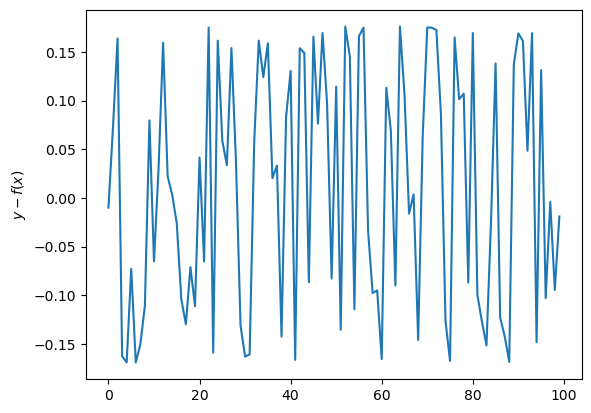

In [217]:
plt.plot(y-model.predict(X))
plt.ylabel(r'$y-f(x)$')

Let's evaluate the percentage error:

Text(0, 0.5, 'percentage error')

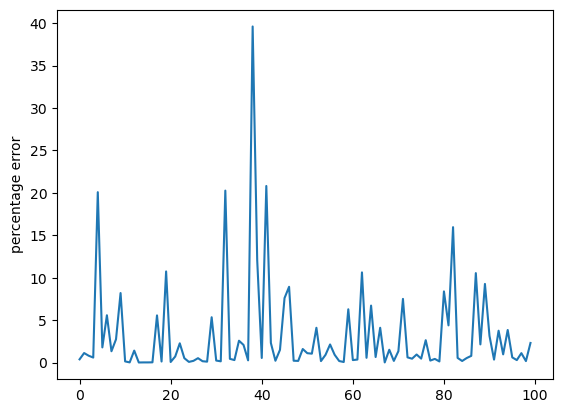

In [232]:
pc_err = 100*np.abs((y-model.predict(X))/y)
err_mean = np.mean(pc_err)
plt.plot(pc_err)
plt.ylabel('percentage error')

there are few critical points, probably these are the ones near zero, where y is small and so the noise is of the same order or pheraps of an higher order of magnitude of y.

In [233]:
md(f'The mean value of the percentage error is: {err_mean}')

The mean value of the percentage error is: 3.191311165892269